# Benchmarking Our Algorithm against others

In [3]:
import sys
sys.path.append('../')
from panav.environment.env import MultiTunnelEnv
from panav.hybrid import HybridGraph
from panav.util import flowtime,makespan
from panav.PBS.PBS import PBS
from panav.TrafficAwarePlanning import TAHP
from panav.sequential import sequential_planning
from panav.PIBT import PIBT_plan
from panav.SAMP.solvers import Tube_Planning



from time import time
import pickle as pkl

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

bloating_r = 0.5
vmax = 1.0

n_agents = list(range(10,101,10))
# n_agents = [6]

TIMEOUT = 100 # timeout

# Algorithms
algs = {  "PIBT": lambda hg: PIBT_plan(hg,vmax,bloating_r,TIMEOUT),
        "S2M2": lambda hg: PBS(hg.env,vmax=vmax,bloating_r=bloating_r,low_level_planner="Simple_MILP_Planning",TIMEOUT=TIMEOUT)[0],
        "PBS_Tube": lambda hg: PBS(hg.env,vmax=vmax,bloating_r=bloating_r,low_level_planner="Tube_Planning",TIMEOUT=TIMEOUT)[0],
        "TAHP": lambda hg: TAHP(hg,vmax=vmax,bloating_r=bloating_r,TIMEOUT=TIMEOUT),
        "Seq_Tube": lambda hg: sequential_planning(Tube_Planning,hg.env,vmax,bloating_r,TIMEOUT=TIMEOUT),      
        # "Seq_Temp_Obs": lambda hg: sequential_planning(Simple_MILP_Planning,hg.env,vmax,bloating_r,TIMEOUT=TIMEOUT)
        }

timeouted = {alg:False for alg in algs}

results = []

env_name = "MultiTunnel"


In [3]:
# Load checkpoint if necessary

with open("./data/{}_misc.pkl".format(env_name),'rb') as fp:
    ck = pkl.load(fp)
    cur_N = ck['cur_N']



with open("./data/{}.pkl".format(env_name),'rb') as fp:
    results = pkl.load(fp)

In [5]:
cur_N = 0
# Experiments
for i in range(len(n_agents)):
    
    N = n_agents[i]
    if N<cur_N:
        continue

    limits = [(-20,20),(-80,80)] 
    n_tunnel = 20

    env = MultiTunnelEnv(n_tunnel = n_tunnel, tunnel_width = bloating_r*2.5,limits=limits, N_agent = N)

    HG = HybridGraph(env,bloating_r)

    # Save checkpoint data
    with open("./data/{}_misc.pkl".format(env_name),'wb') as fp:
        pkl.dump({"TIMEOUT":TIMEOUT,"HG":HG,'cur_N':N},fp)
        
    to_remove = []
    for e in HG.edges:
        if HG.edges[e]['type']=='soft':
            # HG.edges[e]['weight'] = 0
            # pass
            u,v = e
            if HG.nodes[u]['type']== HG.nodes[v]['type']=='tunnel' and \
                                    HG.nodes[u]['open_space_id'] == HG.nodes[v]['open_space_id']:
                to_remove.append(e) # Remove the soft edges connecting two tunnel endpoints for this particular environment
    for e in to_remove:
        HG.remove_edge(*e)

    for name,alg in algs.items():

        if timeouted[name]:
            continue
        
        print("Alg:", name, "N agent:",N)

        result = {}
        
        t0 = time()
        plan = alg(HG)
        t = time()-t0
        
        result['plan'] = plan
        result['time'] = t

        result['N_agent'] = N
        result['alg_name'] = name

        result["TIMEOUT"]=TIMEOUT
        result["HG"]=HG

        results.append(result)

        
        if t>TIMEOUT:
            timeouted[name] = True
            print("Time out for algorithm", name, "N agent = ", N)


        
        

    # Save checkpoint data
    with open("./data/{}.pkl".format(env_name),'wb') as fp:
        pkl.dump(results,fp)


Alg: PIBT N agent: 10
Alg: S2M2 N agent: 10
PBS Time Elapsed: 1.527226209640503
PBS Time Elapsed: 1.6806151866912842
PBS Time Elapsed: 1.9413340091705322
PBS Time Elapsed: 2.1643803119659424
PBS Time Elapsed: 2.4666411876678467
PBS Time Elapsed: 2.7329351902008057
PBS Time Elapsed: 3.167863130569458
PBS Time Elapsed: 3.429431200027466
PBS Time Elapsed: 3.732107162475586
PBS Time Elapsed: 4.261077165603638
PBS Time Elapsed: 4.641489267349243
PBS Time Elapsed: 5.087033271789551
PBS Time Elapsed: 5.872492074966431
PBS Time Elapsed: 6.200346231460571
PBS Time Elapsed: 6.561690092086792
PBS Time Elapsed: 7.347961187362671
PBS Time Elapsed: 7.609499216079712
PBS Time Elapsed: 8.040430068969727
PBS Time Elapsed: 8.507172107696533
PBS Time Elapsed: 9.071654319763184
PBS Time Elapsed: 9.530978202819824
PBS Time Elapsed: 10.045834064483643
PBS Time Elapsed: 10.916469097137451
Skipping ij (5, 9) prev_ordering [(4, 0), (1, 3), (6, 1), (9, 4), (1, 0), (9, 5)]
Skipping ij (9, 5) prev_ordering [(4, 0

/Users/tianpengzhang/opt/miniconda3/envs/PA-NAV/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Alg: S2M2 N agent: 20
PBS Time Elapsed: 2.778991222381592
PBS Time Elapsed: 2.9787380695343018
PBS Time Elapsed: 3.2071101665496826
PBS Time Elapsed: 3.4808781147003174
PBS Time Elapsed: 4.743693113327026
PBS Time Elapsed: 5.086096286773682
PBS Time Elapsed: 5.628724098205566
PBS Time Elapsed: 6.8488781452178955
PBS Time Elapsed: 7.33871603012085
PBS Time Elapsed: 7.786991119384766
PBS Time Elapsed: 8.275394201278687
PBS Time Elapsed: 8.799787044525146
PBS Time Elapsed: 9.280881881713867
PBS Time Elapsed: 10.18189811706543
PBS Time Elapsed: 11.014235258102417
PBS Time Elapsed: 12.842504024505615
PBS Time Elapsed: 15.478416204452515
PBS Time Elapsed: 17.402163982391357
PBS Time Elapsed: 19.14530301094055
PBS Time Elapsed: 19.78341293334961
PBS Time Elapsed: 20.52419114112854
PBS Time Elapsed: 21.06178307533264
PBS Time Elapsed: 22.062283039093018
PBS Time Elapsed: 22.69704818725586
PBS Time Elapsed: 25.293246030807495
PBS Time Elapsed: 26.528529167175293
PBS Time Elapsed: 30.55737018585

/Users/tianpengzhang/opt/miniconda3/envs/PA-NAV/lib/python3.11/site-packages/cvxpy/problems/problem.py:1391: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


Alg: S2M2 N agent: 30
PBS Time Elapsed: 3.871100902557373
PBS Time Elapsed: 4.0610270500183105
PBS Time Elapsed: 4.328164100646973
PBS Time Elapsed: 4.590472936630249
PBS Time Elapsed: 4.777350902557373
PBS Time Elapsed: 5.539534091949463
PBS Time Elapsed: 5.923664808273315
PBS Time Elapsed: 6.18656587600708
PBS Time Elapsed: 6.845179796218872
PBS Time Elapsed: 8.108584880828857
PBS Time Elapsed: 8.298963785171509
PBS Time Elapsed: 8.673990726470947
PBS Time Elapsed: 9.100534915924072
PBS Time Elapsed: 9.891100883483887
PBS Time Elapsed: 10.230362892150879
PBS Time Elapsed: 10.957522869110107
PBS Time Elapsed: 12.353793859481812
PBS Time Elapsed: 13.747179985046387
PBS Time Elapsed: 15.33536672592163
PBS Time Elapsed: 15.812995910644531
PBS Time Elapsed: 16.678679943084717
PBS Time Elapsed: 17.902158737182617
PBS Time Elapsed: 18.43131685256958
PBS Time Elapsed: 18.95757484436035
PBS Time Elapsed: 19.87534189224243
PBS Time Elapsed: 20.921246767044067
PBS Time Elapsed: 22.1524839401245

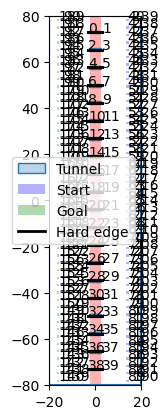

In [9]:
from panav.viz import draw_hybrid

draw_hybrid(HG)